In [2]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn as sk
from sklearn import metrics

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

import umap
import umap.plot

#import gower # calcula matriz de distancias gower
import fastcluster # mejora la performance del cluster jerárquico

# para gridsearch
# https://genieclust.gagolewski.com/
# https://doi.org/10.1016/j.softx.2021.100722
import genieclust

# for everything else
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# trabajo con zip
#from zipfile import ZipFile
#from io import BytesIO

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab20(np.arange(5)), 5)


In [4]:

def grafico_evaluacion(X_train_test, labels_orig, labels_test , nom_test=''):
    '''grafico en el espacio vectorial del pca las clasificaciones realizadas
    X_train_test = coordenadas de lso puntos en PCA -considera slo las primeras 4-
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo
    nom_test     = texto para aclara en el grafico el nombre del clasificador utilizado
    '''
    
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab20(np.arange(5)), 5)

    fig, axs = plt.subplots(2,2)
    axs[0,0].scatter(X_train_test[:,0],X_train_test[:,1],s=1,c=labels_test, alpha=0.5, cmap=cmap)
    axs[0,0].set_xlabel('PC1')
    axs[0,0].set_ylabel('PC2')
    axs[0,1].scatter(X_train_test[:,2],X_train_test[:,3],s=1,c=labels_test, alpha=0.5, cmap=cmap)
    axs[0,1].set_xlabel('PC3')
    axs[0,1].set_ylabel('PC4')
    
    
    axs[1,0].scatter(X_train_test[:,0],X_train_test[:,1],s=1,c=labels_orig, alpha=0.5, cmap=cmap)
    axs[1,0].set_xlabel('PC1')
    axs[1,0].set_ylabel('PC2')
    axs[1,1].scatter(X_train_test[:,2],X_train_test[:,3],s=1,c=labels_orig, alpha=0.5, cmap=cmap)
    axs[1,1].set_xlabel('PC3')
    axs[1,1].set_ylabel('PC4')
    
    
    axs[0,0].set_title(f'{nom_test}')
    axs[0,1].set_title(f'{nom_test}')
    axs[1,0].set_title('real')
    axs[1,1].set_title('real')
    fig.set_constrained_layout('constrained')
    return None

def cross_tab(Labels_orig, Labels_clust):
    '''crea matriz de confusión para evaluar etiquetado
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo'''
    tmp = pd.DataFrame({'Labels_orig': Labels_orig, 'Labels_clust': Labels_clust})
    ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
    rand = metrics.rand_score(Labels_orig, Labels_clust)
    arand= metrics.adjusted_rand_score(Labels_orig, Labels_clust)
    print(f'RAND score={rand:.4f}, Ajusted RAND={arand:.4f}, cantidad_de_muestras={len(Labels_orig):,d}')
    return ct


In [5]:
def leo_y_consolido_features(input_path='./input/'):
    df1 = pd.read_csv(input_path+'features_Arborio.csv')
    df2 = pd.read_csv(input_path+'features_Basmati.csv')
    df3 = pd.read_csv(input_path+'features_Ipsala.csv')
    df4 = pd.read_csv(input_path+'features_Jasmine.csv')
    df5 = pd.read_csv(input_path+'features_Karacadag.csv')
    features = np.array(pd.concat([df1,df2,df3,df4,df5], axis =0))
    return features
    
def paso_a_pca(features, guardo=False, archivo_guarda=None):
    # reduce the amount of dimensions in the feature vector
    pca = PCA(n_components=100, random_state=22)
    pca.fit(features)
    x = pca.transform(features)
    if guardo:
        archivo_pca = archivo_guarda
        pd.DataFrame(x).to_csv(archivo_pca, index=False)
    # grafico varianza explicada
    ax = plt.subplot()
    ax.plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
    ax.set_xlim([0,15])
    ax.set_xlabel('PCs')
    ax.set_ylabel('Var. explicada (%)')
    return x

ARCHIVO_PCA = 'C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/feat_pca.csv'
INPUT_P = 'C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/unsupervised-rice-image-segmentation/input/'

# x = paso_a_pca(leo_y_consolido_features(input_path=INPUT_P),
#                guardo=True, archivo_guarda=ARCHIVO_PCA)

x = pd.read_csv(ARCHIVO_PCA).to_numpy()

In [25]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    colors = plt.cm.tab20(np.arange(6))
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

#%%
def dendro(hclust, color_threshold=150  ):
    fig = plt.figure(figsize=(15,4))
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    linkage_matrix = plot_dendrogram(hclust, p=3, leaf_rotation=45, truncate_mode="level", color_threshold=color_threshold)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()
    return linkage_matrix


In [7]:
# divido dataset hay que considerar el tamaño según el método porque algunos toman mucho tiempo


# como están ordenadas por clase voy a hacer una lista con las etiquetas ahora antes de mezclarlas
clases_dict = {0:'Arborio', 1:'Basmati', 2:'Ipsala', 3:'Jasmine', 4:'Karacadag'}
lista_clases = ([0]*15000 + [1]*15000 + [2]*15000 + [3]*15000 + [4]*15000)


# separo en train_test y validación con sus respectivas etiquetas y los mezclo
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(x, lista_clases, test_size=0.2, random_state=42)

org_lab = pd.Series(y_train_test).map(clases_dict)

In [8]:
del x, X_val, y_val, lista_clases

RAND score=0.8094, Ajusted RAND=0.4055, cantidad_de_muestras=60,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,1157,0,46,2,11090
1,57,5889,12,4427,0
2,139,6076,76,5860,0
3,5661,6,5816,499,853
4,4989,34,5967,1216,128


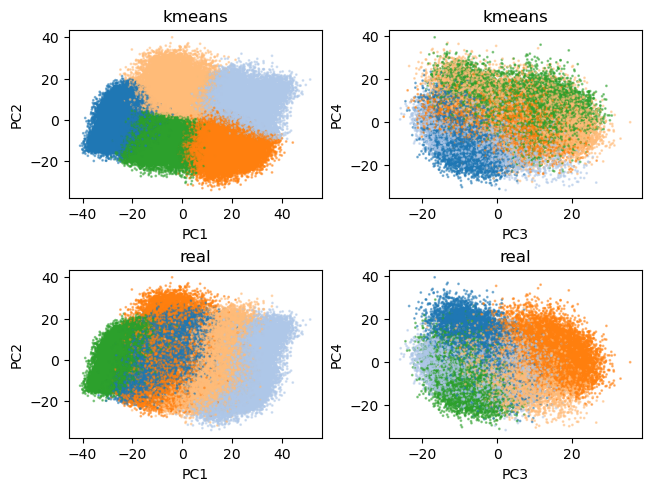

In [9]:
# aplico kmeans, esto porque es rápido y me sirve de punto de comparación


#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=5, n_init='auto')
kmeans.fit(X_train_test)


grafico_evaluacion(X_train_test, y_train_test, kmeans.labels_ , nom_test='kmeans')
cross_tab(org_lab, kmeans.labels_)


RAND score=0.8420, Ajusted RAND=0.5820, cantidad_de_muestras=60,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,9019,0,102,39,12053
1,7,0,11712,94,0
2,73,9554,63,11831,0
3,0,2451,0,23,0
4,2904,0,40,17,18


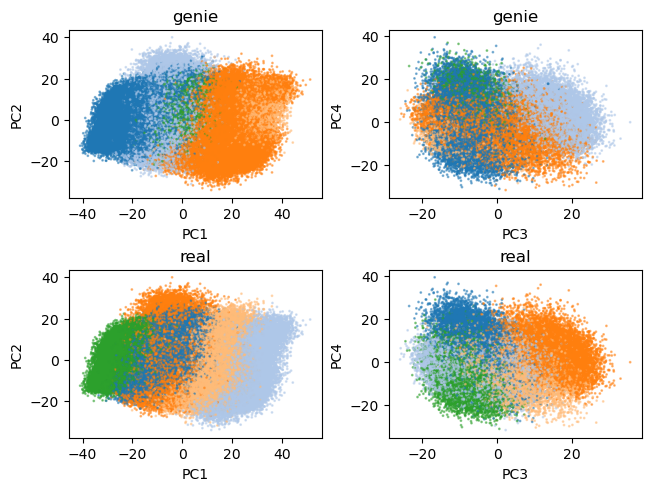

In [7]:
# aplico genieclust (mejora la clasificación con más datos)

g = genieclust.Genie(n_clusters=5)
labels_genie = g.fit_predict(X_train_test)


grafico_evaluacion(X_train_test, y_train_test, labels_genie , nom_test='genie')
cross_tab(org_lab, labels_genie)

In [18]:
# calculo distancias gower
# TARDA MUCHO, OJO CON LA CANTIDAD DE DATOS

#armo matriz de distancias
# en colab cuelga por falta de ram, local funciona
# d_meta = gower.gower_matrix(X_train_test)

<Axes: >

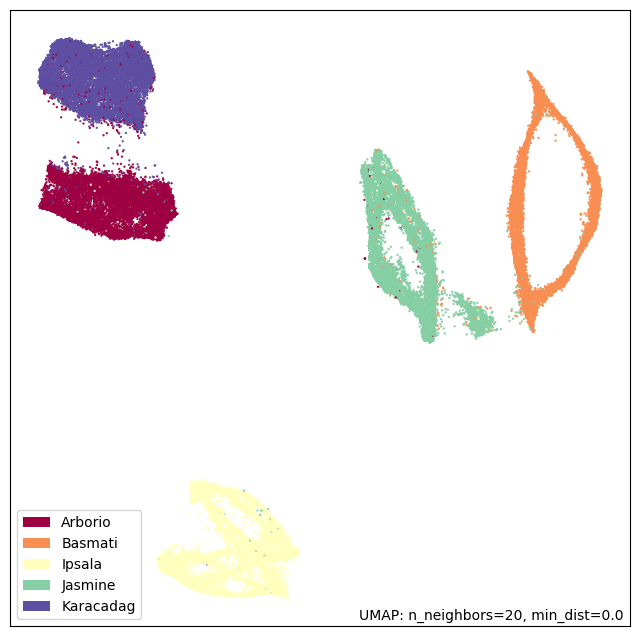

In [30]:
#Realizo UMAP reducción de dimensiones desde pca con UMAP y clasifico

um = umap.UMAP(n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean', random_state=42)
Xred = um.fit_transform(X_train_test)

#genie_umap = genieclust.Genie(n_clusters=5).fit_predict(Xred)
#kmeans_umap = KMeans(n_clusters=5, n_init='auto').fit_predict(Xred)

umap.plot.points(um, labels=org_lab)
#umap.plot.connectivity(um, show_points=True, labels=org_lab)


In [31]:
# calculo para PCA
hclust_pca = AgglomerativeClustering(n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=2500 )
label_pca = hclust_pca.fit_predict(X_train_test)

# calculo para UMAP
hclust_umap = AgglomerativeClustering( n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=350 )
label_umap = hclust_umap.fit_predict(Xred)

In [32]:
print('AgglomerativeClustering', "n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=2500")
print(cross_tab(org_lab, hclust_pca.labels_))
print()
print('AgglomerativeClustering UMAP') 
print('AgglomerativeClustering params:',"n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=350")
print('UMAP params:', "n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean")
print(cross_tab(org_lab, hclust_umap.labels_))

AgglomerativeClustering n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=2500
RAND score=0.8254, Ajusted RAND=0.4689, cantidad_de_muestras=60,000
Labels_orig   Arborio  Basmati  Ipsala  Jasmine  Karacadag
Labels_clust                                              
0                  50     8519      59     7948          1
1                 705        0      16        5      11365
2                7146        2    6736       69        272
3                4088        1    5060       75        433
4                  14     3483      46     3907          0

AgglomerativeClustering UMAP
AgglomerativeClustering params: n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=350
UMAP params: n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean
RAND score=0.9481, Ajusted RAND=0.8295, cantidad_de_muestras=60,000
Labels_orig   Arborio  Basmati  Ipsala  Jasmine  Karacadag
Labels_clust                                              
0        

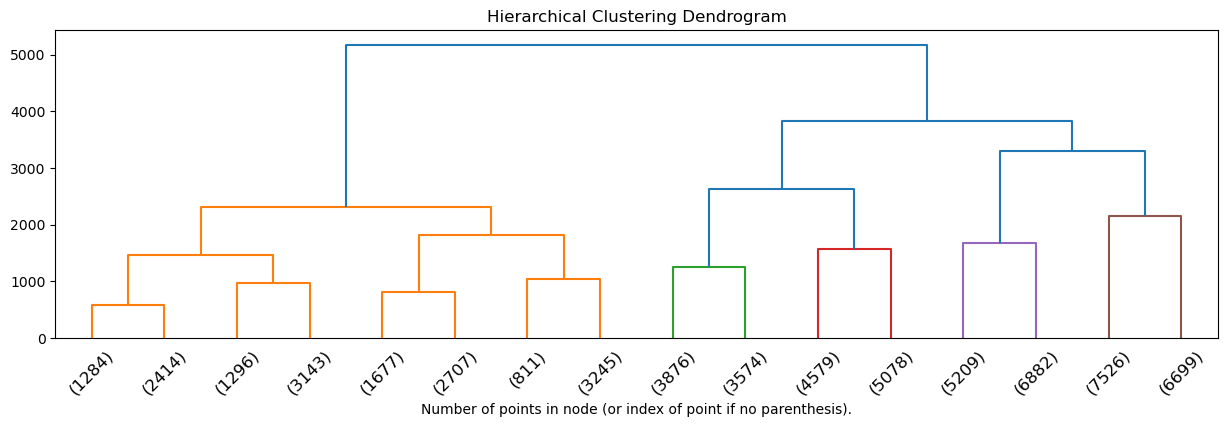

In [33]:
# dendrograma desde PCA
mx_pca = dendro(hclust_pca, color_threshold=2500, )

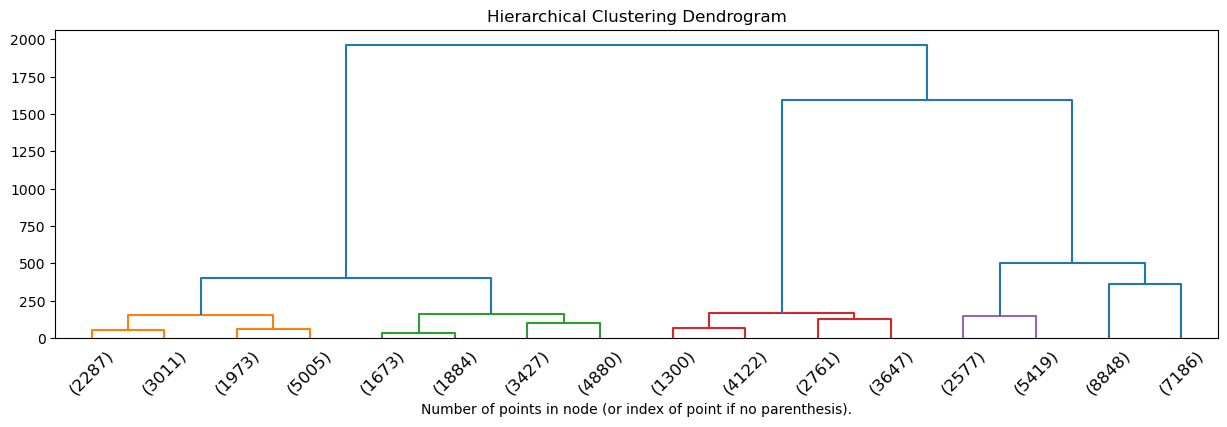

In [34]:
# dendrograma desde UMAP
mx_umap = dendro(hclust_umap, color_threshold=350)

<Axes: >

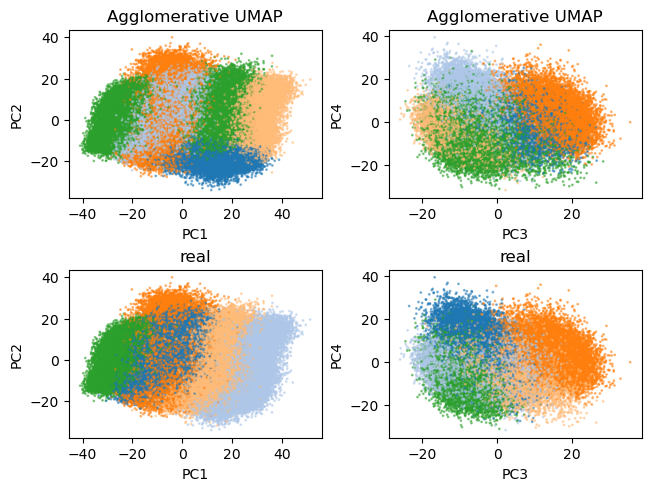

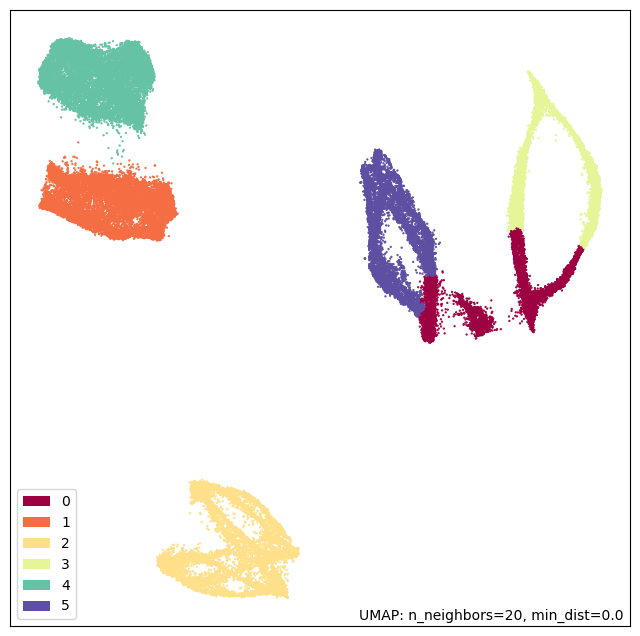

In [35]:
grafico_evaluacion(X_train_test, y_train_test, hclust_umap.labels_ , nom_test='Agglomerative UMAP')

umap.plot.points(um, labels=hclust_umap.labels_)